In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
band = 'Ks'

In [3]:
# Load in data
tbl = pd.read_csv('preprocessed_data_avg.csv')
tbl = tbl[tbl['Filter']==band] 

# load in new nH's 
new_flux = pd.read_csv('FSRED Mags - different_nH.csv')


In [4]:
# TODO determine luminosities based on flux and distance
def luminosity(flux, d):
    d_cm = 3.08567758128e21 * float(d) 
    L = 4 * np.pi * d_cm**2 * flux

    return L


def luminosity_error(flux, flux_error, d, d_error, L):
    L_err = np.sqrt((flux_error/flux)**2 + 2*(d_error/float(d))**2) * L

    return L_err

In [5]:
print(tbl[tbl['Source']=='2S_0918-549']['log_L_X'])

for index, row in tbl.iterrows():

    if row['Source'] in new_flux['Source'].tolist():
        L_old = row['log_L_X']
        flux = new_flux[new_flux['Source'] == row['Source']]['X_flux_heanh'].values[0] 
        d = row['Distance (kpc)']
        L_X = luminosity(flux, d)
        row['log_L_X'] = np.log10(L_X)
        logL = np.log10(L_X)
        tbl['log_L_X'] = tbl['log_L_X'].replace([L_old], logL)
        
print(tbl[tbl['Source']=='2S_0918-549']['log_L_X'])


13    36.1038
Name: log_L_X, dtype: float64
13    35.80515
Name: log_L_X, dtype: float64


C:\Users\Iris Reitsma\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


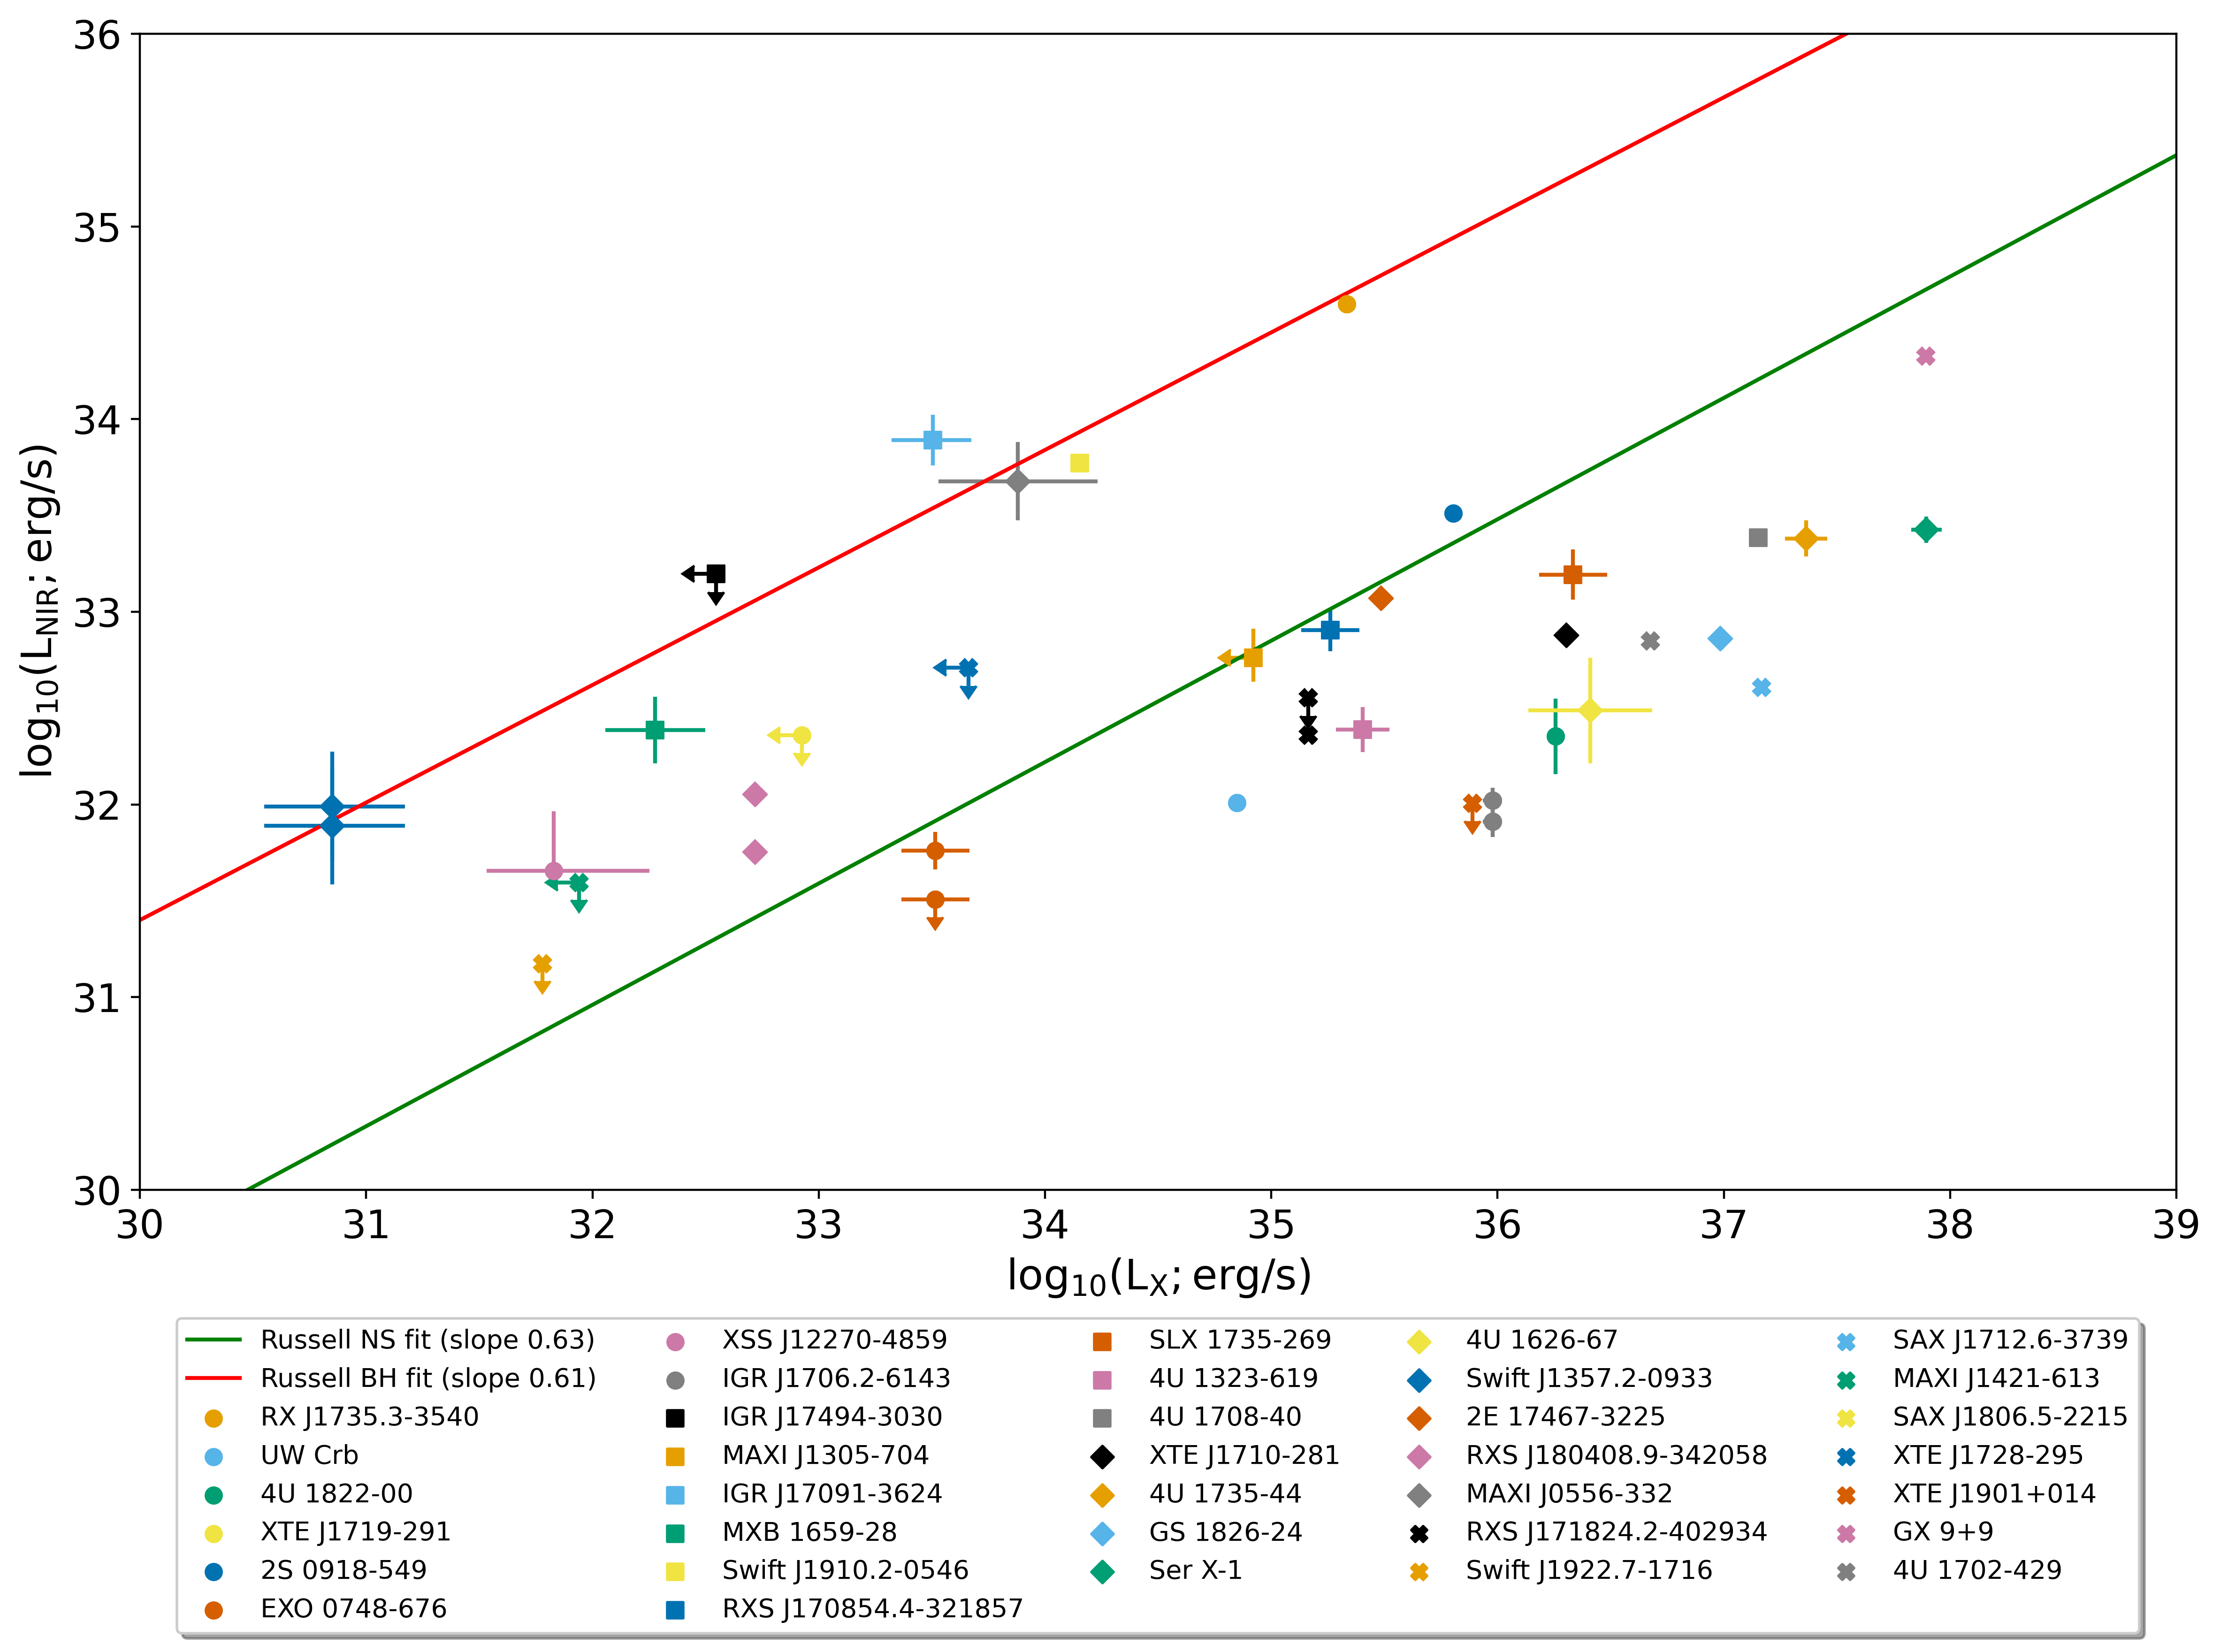

In [6]:
def plotfunc_scatter(ax, tbl, color, shape, label): 
    
    # Remove underscore from labels
    label = label.replace('_', ' ')
    # Plot regular data points 
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10) 
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], [tbl['log_L_NIR_errup']]], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], marker=shape, fmt='o', color=color)

    # Plot points with only upplim on NIR luminosity
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)      
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], uplims = True, marker=shape, fmt='o', color=color)

    # Plot points with only upplim on X-ray luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], tbl[['log_L_NIR_errup']]], xerr=[tbl['log_L_X_upplim']*arrow_scale], xuplims = True, marker=shape, fmt='o', color=color)

    # Plot points with upplims on X-ray luminosity and NIR luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[tbl['log_L_X_upplim']*arrow_scale], uplims=True, xuplims=True, marker=shape,fmt='o', color=color)





    
fig, ax = plt.subplots(figsize = (14, 8), dpi=400)
xrange= np.logspace(29, 41, num=10)
y = 10**10.8 * xrange**(0.63)
ax.plot(np.log10(xrange), np.log10(y), c='g', label='Russell NS fit (slope 0.63)')
y_bh = 10**13.1 * xrange**0.61
ax.plot(np.log10(xrange), np.log10(y_bh), c='r', label='Russell BH fit (slope 0.61)')
markers = ['o', 's', 'D', 'X', '*']
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", 'grey']
options = np.array(np.meshgrid(markers, colors)).T.reshape(-1,2)
# print(options)

arrow_scale = 0.2 / np.log(10) / 30


i = 0
last_source = 'first'
for n, s in enumerate(tbl['Source']):

    # exclude not plotted sources from legend
    if np.isnan(tbl.iloc[n]['L_NIR']) and np.isnan(tbl.iloc[n]['L_NIR_upplim']) or np.isnan(tbl.iloc[n]['L_X']) and np.isnan(tbl.iloc[n]['L_X_upplim']):
        continue
        
    # every source gets a new shape-color combination
    if s != last_source: 
        i +=1
    shape = options[i][0]
    color = options[i][1]
    last_source = s
    
    # scatter plot the data for which luminosites are available
    try: 
        plotfunc_scatter(ax, tbl.iloc[n], color, shape, s)
    except:
        continue
        
ax.set_xlabel(r'$\mathrm{log_{10}(L_{X}; erg/s)}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{log_{10}(L_{NIR}; erg/s)}$', fontsize=16)
ax.set_xlim(30, 39)
ax.set_ylim(30, 36)
# ax.set_xlim(30, 40)
# ax.set_ylim(29, 39)
ax.tick_params(axis='both', labelsize=15)

# remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()